# Watershed Model

## Model Description 
This is a steady state, layered box model with 3 scenarios

#### Dimensions: 
- 50 by 50 by 1
- dx = dy = 1000 m
- dz = bottom 40 m, middle 5 m, top defined in excel  

#### Subsurface Properties: 
- Heterogeneous
- K = 8.5 m/d bottom layer
- K = 8.5 m/d middle layer 
- K = 0.0001 m/d in z direction in remaining columns
- Porosity = 0.10
- Specific yield = 0.10
- Storage coefficient=0.0001 

#### Stream Properties:
- Streambed width = 1 m
- Streambed thickness = 1 m
- Stream bottom depth = 1 m
- Stream stage = 0.5 m
- Streambed slope = 0.001
- Streambed rough = 0.04
- Streambed K = 1.36*k_horizontal m/day

## 1. Setup the environment

In [156]:
#the basics
import flopy
import numpy as np
import matplotlib as mp
import os

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv

#jupyter specific--included to show plots in notebook
%matplotlib inline 

## 2. Setup the input variables 

In [157]:
## Model directory
moddir="D:/HOMEWORK/homework-ksamolov/Working/HW2_BoxModel_manual/starter_code/mf2005"

## Discretization
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 3  #number of layers

dx= 1000 #width of grid cells in x direction 
dy= 1000 #width of grid cells in y direction 

Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y

## Topography
with open('BASE_top_elev.csv', 'r', encoding='utf-8-sig') as reader: 
    # this reads the csv in as an array
    ztop = np.genfromtxt(reader, dtype=float, delimiter=',') # top elevation of top layer (import from csv file) (dim: nrow,ncol)

zbot = 0.     #bottom elevation


dz = (ztop - zbot) / nlay #cell height in z direction

## Timing
nper = 1 #number of stress periods 
steady = [True] #list noting the stress period type

## Subsurface properties
K_horiz = 8.5    #assign horizontal hydraulic conductivity 
K_vert = 8.5    #assign vertical hydraulic conductivity (along z axis)
n = 0.1        #assign porosity
ss = np.ones((nlay,nrow,ncol), dtype=np.float)        #define specific storage
ss[:,:,:] = 0.0001 #assign storage coefficient
Sy = 0.1        #assign specific yield
uncnf = 1       #0=confined, >0 = unconfined

## Recharge
recharge = 4e-5 #m/day

## Boundary conditions
h_right = 70

C:\Users\LIFEBOOK\AppData\Local\Temp\ipykernel_4484\1112679690.py:33: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ss = np.ones((nlay,nrow,ncol), dtype=np.float)        #define specific storage


# 3. Setup and run MODFLOW for three scenarios

## 3.1. Scenario 1 - No Town and No Agriculture

In [158]:
#Initialize the model
modelname1 = "NANT"

m1 = flopy.modflow.Modflow(modelname1, exe_name = moddir)

botm = np.zeros((nlay,nrow,ncol))  # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[1,:,:] = 40.                  # bottom elevation of middle layer (1) is 40 m
botm[0,:,:] = 45.                  # bottom elevation of top layer (0) is 45 m 

## Make arrays for the K values
Kz = np.zeros((nlay,nrow,ncol))      # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = K_vert                   # assign the original value to the entire array
Kz[1,:,21:50] = K_vert * 2.1e-2       # Replace the K in the middle layer with the lower value

Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz                  # assign the original value to the entire array
Kh[1,:,:] = 0.0001                   # Replace the K in the middle layer with the lower value

#Discretization - dis
dis = flopy.modflow.ModflowDis(model=m1, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)

#Boundary and initial conditions
#Define cell activity (IBOUND)
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active                                                     
ibound[:,:,49] = -1         #replace rightmost column (all zs, all ys, first x) with -1 to indicate constant head
ibound[:,:,0] = 0

#Loop for boundary
for i in range (0,6):
    ibound[0:, i, 0:6-i] = 0
for i in range (0,8):
    ibound[1, i, 0:8-i] = 0
for i in range (0,10):
    ibound[2, i, 0:10-i] = 0
for i in range (0,6):
    ibound[0:, 44+i, 0:1+i] = 0
for i in range (0,8):
    ibound[1, 42+i, 0:1+i] = 0
for i in range (0,10):
    ibound[2, 40+i, 0:1+i] = 0

## Other Boundaries are no flow - inactive cells
ibound[:,0, :] = 0
ibound[:,-1, :] = 0

#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, :] = h_right    #initialize the entire domain to the right head value

bas = flopy.modflow.ModflowBas(m1, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m1, laytyp=uncnf, hk=K_horiz, 
                               vka=K_vert, ss=ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 

#Setup the Stream - STR Object
k_strbott = 1.36 * K_horiz    #river bottom hydraulic conductivity in m/d
sed_thick = 1                      #thickness of riverbed sediment in m
slope = 0.001                        #slope of streambed (m/m)
rough = 0.04                         #roughness of streambed
width = 1                           #x-sectional width of channel (m)
nseg = 3                            #number of stream segments 
ntrib = 2                           #number of stream tributaries that can connect to one segment
Flow_into_the_1st_reach = 0    # m^3/day
Stage_above_datum = 0.5 # m^3/day; top of streambed is at 8 m (incl 1 m of streambed thickness)

#str settings
set_icalc = 0                   #1 if the stage is to be calculated based on flow, otherwise specify below
                            # Set icalc = 0 stage doesn't change
str_spd1 = []                      #create list to store all river cells for stress period 1
const = 86400.0                      #multiplication constant for m3/day - see documentation for other units
istcb2 = 53                          #save outflows to cbb file

#calculated values
cond = k_strbott*(dy)*(dx)/(sed_thick) #river bed conductance
cond_vals = np.ones(nrow)
str_stage = Stage_above_datum

#if set_icalc > 0:      #Calculating the stage for graphing using Manning formula
#str_stage = str_top + ((Flow_into_the_1st_reach*rough)/(const*width*(slope**0.5)))**0.6   
#print("Calculated stage at inflow =", str_stage)

#Adding str package with only 1 stress period and one segment
strd = {}  
strspd = []
for y in range(ncol):
    str_bott = ztop[24,y]-2  #river bottom is defined as the ztop at row 25 minus 2
    str_top = str_bott+sed_thick #stream top is stream bottom + sed thickness
    add = [0, nrow/2, y, 1, y+1, Flow_into_the_1st_reach, str_stage, cond_vals[y], str_bott, str_top, width, slope, rough]
    strspd.append(add)
strd[0]=strspd   
seg_info = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   #create segment info array - all zeros since only one segment
str_segd = {0: seg_info}                       #create dict of segment info keyed to stress periods

strm = flopy.modflow.mfstr.ModflowStr(m1, mxacts=75, nss=1, ntrib=0, ndiv=0,icalc= set_icalc, const=const, ipakcb=53,  istcb2=istcb2, dtype=None,
        stress_period_data=strd, segment_data=str_segd, extension='str') 

print(cond_vals)

#Recharge 
rech_zone = np.zeros((nrow,ncol))  #define an array of zeros of dim (nrow,ncol)
rech_zone[:,0:15]=recharge
#print(rech_zone)
rch = flopy.modflow.mfrch.ModflowRch(model=m1, rech=rech_zone, ipakcb=53)  #create rch object

#ET Object
ET_zone = np.zeros((nrow,ncol))     # define an array of zeroes the size of the model grid
riv_et = 5e-4  #set background ET value m/day
back_et = 1e-5
ET_zone[:, 25:49] = ET_zone[:, 25:49] +back_et
ET_zone[21:29,:] = ET_zone[21:29,:] + riv_et  #apply riv et to the right section
extinction_depth = 1

evt = flopy.modflow.mfevt.ModflowEvt(model=m1, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53) 

#Output control - OC 
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
oc = flopy.modflow.ModflowOc(model=m1, stress_period_data=spd, compact=True)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m1) 

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]


## 3.2. Scenario 2 - No Agriculture Yes Town

In [159]:
#Initialize the model
modelname2 = "NAYT"
m2 = flopy.modflow.Modflow(modelname2, exe_name = moddir)

#Discretization - dis
# no changes because we have the base case working
dis = flopy.modflow.ModflowDis(model=m2, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)


# Boundary and initial conditions - bas
bas = flopy.modflow.ModflowBas(m2, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m2, laytyp=uncnf, hk=K_horiz, 
                               vka=K_vert, ss=ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 
#Recharge 
rch = flopy.modflow.mfrch.ModflowRch(model=m2, rech=rech_zone, ipakcb=53)  #create rch object

#ET
evt = flopy.modflow.mfevt.ModflowEvt(model=m2, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53) 

#Output control - OC 
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
oc = flopy.modflow.ModflowOc(model=m2, stress_period_data=spd, compact=True)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m2)

#Town Well
#well location is in the 3rd layer (bottom)
well = (2,21,38) #well location layer, row, column
Q_in = -1810                #volumetric flux from the well in units of m3/day 
fluxes = [2,21,38,Q_in]

sp_fluxes = {0: fluxes}              #create a dictionary with entries for each stress period

well = flopy.modflow.ModflowWel(model=m2, stress_period_data=sp_fluxes)

#Set Up Stream
k_strbott = 1.36 * K_horiz    #river bottom hydraulic conductivity in m/d
sed_thick = 1                      #thickness of riverbed sediment in m
slope = 0.001                        #slope of streambed (m/m)
rough = 0.04                         #roughness of streambed
width = 1                           #x-sectional width of channel (m)
nseg = 3                            #number of stream segments 
ntrib = 2                           #number of stream tributaries that can connect to one segment
Flow_into_the_1st_reach = 0    # m^3/day
Stage_above_datum = 0.5 # m^3/day; top of streambed is at 8 m (incl 1 m of streambed thickness)

#Stream with Reaches for the Town
#Setup the reach locations – here the row value will be 25 for each reach and the column values will go from 0-49
nreach =  50   # river extending the width of the domain
str_rows = 25*np.ones((nreach),dtype=np.int32)  # integer array of row #s for each reach 
str_cols = np.arange(0,nreach)  # integer array of cols for each reach 

#Setup the inflows for the reaches
Qreturn = 50     # return flow from the town
return_loc = 25    #specifying the column where the town return flows come in
ntrib = 1 # number of triubtaries that can connect. We only have 2
reach_flow = np.zeros((nreach),dtype=np.int32)  # initially set all inflows to zero for all reaches
reach_flow[return_loc] = Qreturn # inflow to seg2 = return from town
reach_flow[return_loc+1] = -1 # inflow to seg3 = sum of all previous segs

#setup segment numbers – this is a list of segment values that goes with each reach
segments = np.ones((nreach),dtype=np.int32)    # make a segment array that is nreach long and initialize all the values to 1
segments[return_loc] = 2    #Change the segment number to ‘2’ where the town recharge comes in
segments[return_loc+1:nreach] = 3    # Change the segment number to ‘3’ everywhere downstream of the the town well

#setup reach numbers – this will be the numbering of the reaches within each segment. 
# Recall that numbering starts and one and increases moving downstream
reaches = np.arange(1,nreach+1)   # create an array of reach #s counting from 1-50
reaches[return_loc] = 1    # reassign the reach number to be 1 for segment 2
reaches[return_loc+1:nreach] = np.arange(1,nreach-(return_loc+1)+1)  # reassign the reach numbers for segment 3 to start counting at 1

## Set Up Stream Elevation
ztop = np.genfromtxt('BASE_top_elev.csv', delimiter=',') # top elevation of top layer (import from csv file) (dim: nrow, ncol)
surf_elev = np.zeros((nreach))   # create array of zeros the length of the stream

# loop over the stream reaches and pull the land surface elevation for the location of each stream cell
for i in np.arange(nreach): 
      surf_elev[i] = ztop[str_rows[i],str_cols[i]]

print(surf_elev)
Stop = surf_elev - 1    # elevation of the top of the streambed (1 m below land surface) (m)
Sbot = Stop - sed_thick      # elevation of the bottom of the streambed (m)
stage_elev = Stop + str_stage     # elevation of the water surface in the stream (m)

## Setup the stress period dictionary
str_info = np.zeros((nreach,13)) # create array of zeros for reaches, each reach requires 13 input values

# Loop over the reaches and setup the data
for r in np.arange(nreach): 
     str_info[r,:] = [0, str_rows[r], str_cols[r], segments[r], reaches[r], reach_flow[r], stage_elev[r], cond, Sbot[r], Stop[r], width,  slope, rough]
str_spd = {0: str_info} # save the stream info in a stress period dictionary

#Setup the segments dictionary
#for each segment, need an array of 10 zeros, for last segment, first two values are seg numbers of upstream segments

seg_info = np.zeros((10,nseg))
seg_info = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1]]
str_segd = {0: seg_info}  #save the stream info in a segment dictionary

#Setup the mudflow package call
strm = flopy.modflow.mfstr.ModflowStr(m2, mxacts=nreach, nss=nseg, ntrib=ntrib, ndiv=0,icalc=set_icalc, const=const, ipakcb=53, istcb2=53, dtype=None, stress_period_data=str_spd, segment_data=str_segd, extension='str')

#write the inputs
m2.write_input()    

[100.   99.   98.   97.   96.   95.   94.   93.   92.   91.   90.   89.
  88.   87.   86.   85.   84.   83.   82.   81.   80.   79.   78.   77.
  76.   75.9  75.8  75.7  75.6  75.5  75.4  75.3  75.2  75.1  75.   74.9
  74.8  74.7  74.6  74.5  74.4  74.3  74.2  74.1  74.   73.9  73.8  73.7
  73.6  73.5]


## 3.3. Scenario 3 - Yes Agriculture Yes Town

In [160]:
# Gather Packages and Such for the Town and Agriculture Scenario
modelname3 = "YAYT"
m3 = flopy.modflow.Modflow(modelname3, exe_name = moddir)

#Discretization - dis
# no changes because we have the base case working
dis = flopy.modflow.ModflowDis(model=m3, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)
#Boundary and initial conditions - bas
bas = flopy.modflow.ModflowBas(m3, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m3, laytyp=uncnf, hk=K_horiz, 
                               vka=K_vert, ss=ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 
#Recharge 
recharge_farm = 0.0012
rech_zone[:,0:15]=recharge
rech_zone[21:23,19:21] = recharge_farm
rch = flopy.modflow.mfrch.ModflowRch(model=m3, rech=rech_zone, ipakcb=53)  #create rch object

#ET
ET_zone[:, 25:49] = ET_zone[:, 25:49] +back_et
ET_zone[21:29,:] = ET_zone[21:29,:] + riv_et  #apply riv et to the right section
ET_zone[21:23,19:21] = 0 # ET on the farm is 0
evt = flopy.modflow.mfevt.ModflowEvt(model=m3, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53) 


#Output control - OC 
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
oc = flopy.modflow.ModflowOc(model=m3, stress_period_data=spd, compact=True)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m3)

#Wells
 #Town well
Q_in1 = -1810                       # Volumetric flux from the well in units of m3/day 
fluxes1 = [0,21,38,Q_in1]

#farm well
Q_in2 = -0.003*(1/8)
fluxes2 = [0,12,14,Q_in1]
sp_fluxes = {0: fluxes1, 0: fluxes2} 
wel = flopy.modflow.ModflowWel(model=m3, stress_period_data=sp_fluxes)

#Stream Reaches for Town
strm = flopy.modflow.mfstr.ModflowStr(m3, mxacts=nreach, nss=nseg, ntrib=ntrib, ndiv=0,icalc=set_icalc, const=const, ipakcb=53, istcb2=53, dtype=None, stress_period_data=str_spd, segment_data=str_segd, extension='str')


#write the inputs
m3.write_input()    

## 4. Plot the domains
### 4.1. Plot model grid and boundary conditions

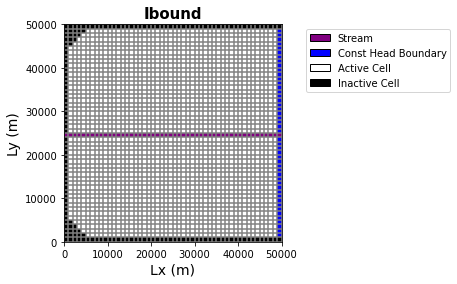

In [161]:
#Plot
modelmap = flopy.plot.PlotMapView(model=m1, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
#wel_m = modelmap.plot_bc("WEL")
str_m = modelmap.plot_bc("STR")
plt.legend(handles=[mp.patches.Patch(color='purple',label='Stream',ec='black'),
                   mp.patches.Patch(color='blue',label='Const Head Boundary',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.8,1.0))
plt.show(modelmap)

## 4.2. Plot cross-section of the layered model

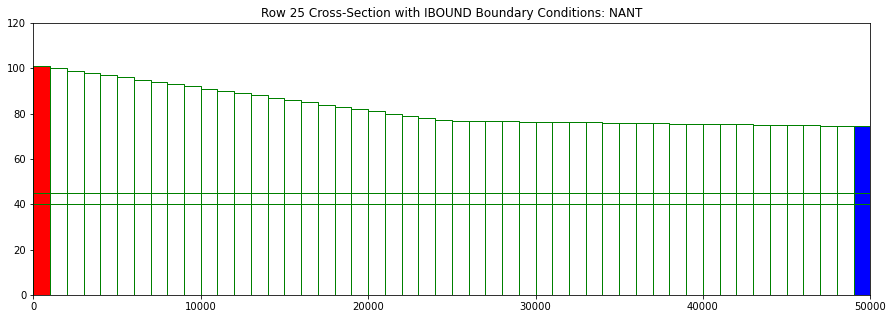

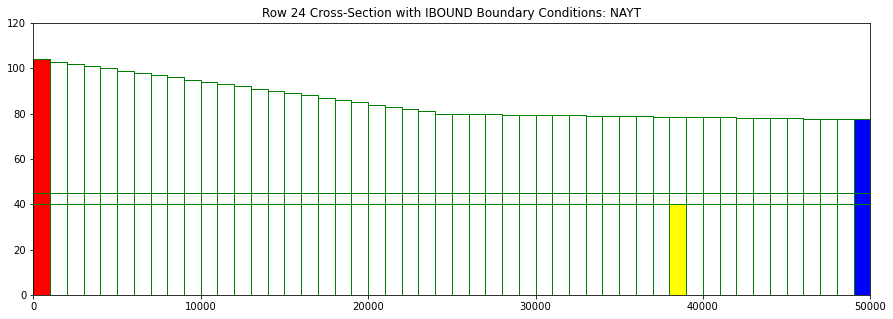

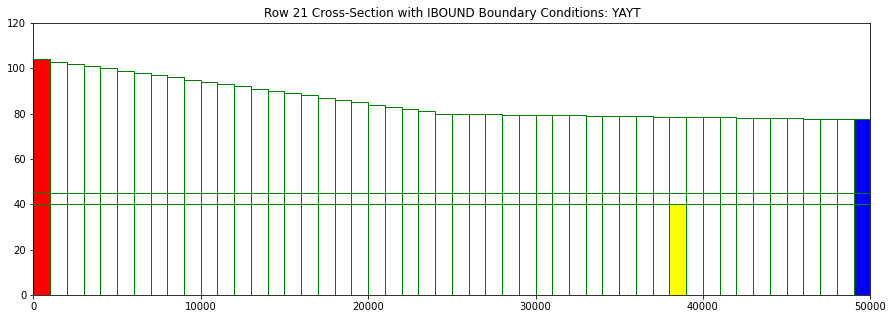

In [162]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

#Layer 1
xsect = flopy.plot.PlotCrossSection(model=m1, line={'row': 24}, extent=(0,50000,0,120)) #note use the key 'column' if you want to plot a column instead
patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='yellow')
linecollection = xsect.plot_grid(color='green')
t = ax.set_title('Row 25 Cross-Section with IBOUND Boundary Conditions: NANT')

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

#Layer 2
xsect = flopy.plot.PlotCrossSection(model=m2, line={'row': 21}, extent=(0,50000,0,120)) #note use the key 'column' if you want to plot a column instead
patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
patches = xsect.plot_bc('WEL', color='yellow')
linecollection = xsect.plot_grid(color='green')
t = ax.set_title('Row 24 Cross-Section with IBOUND Boundary Conditions: NAYT')

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

#Layer 3
xsect = flopy.plot.PlotCrossSection(model=m2, line={'row': 21}, extent=(0,50000,0,120)) #note use the key 'column' if you want to plot a column instead
patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
patches = xsect.plot_bc('WEL', color='yellow')
linecollection = xsect.plot_grid(color='green')
t = ax.set_title('Row 21 Cross-Section with IBOUND Boundary Conditions: YAYT')

# 5. Read in the outputs

### 5.1 Modflow outputs - Heads and budget files

In [163]:
#Head - 1 layer model 
headobj1 = bf.HeadFile(modelname1+'.hds')    #reads the binary head file
times = headobj1.get_times()                 #returns a list of timesteps
head1 = headobj1.get_data(totim=times[-1])   #returns a numpy array of heads for specified time (last timestep)

#Head - 3 layer model 
headobj3 = bf.HeadFile(modelname3+'.hds')    #reads the binary head file
times = headobj3.get_times()                 #returns a list of timesteps
head3 = headobj3.get_data(totim=times[-1])   #returns a numpy array of heads for specified time (last timestep)


#Water balance - 1 layer
budgobj1 = bf.CellBudgetFile(modelname1+'.cbc')   #reads the cell budget file    
print(budgobj1.get_unique_record_names())
kstpkper_list1 = budgobj1.get_kstpkper()          #returns a list of stress periods & timesteps
frf1 = budgobj1.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff1 = budgobj1.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
recharge1 = budgobj1.get_data(text='RECHARGE', totim=1.0) 


#Water balance - 3 layer
budgobj3 = bf.CellBudgetFile(modelname3+'.cbc')   #reads the cell budget file    
print(budgobj3.get_unique_record_names())
kstpkper_list3 = budgobj1.get_kstpkper()          #returns a list of stress periods & timesteps
frf3 = budgobj3.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff3 = budgobj3.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
recharge3 = budgobj3.get_data(text='RECHARGE', totim=1.0) 
print(len(frf3))

[b'   CONSTANT HEAD', b'FLOW RIGHT FACE ', b'FLOW FRONT FACE ', b'FLOW LOWER FACE ', b'              ET', b'        RECHARGE', b'  STREAM LEAKAGE', b'STREAM FLOW OUT ']
[b'   CONSTANT HEAD', b'FLOW RIGHT FACE ', b'FLOW FRONT FACE ', b'FLOW LOWER FACE ', b'              ET', b'        RECHARGE']
1


## 6. Plot cross-sections

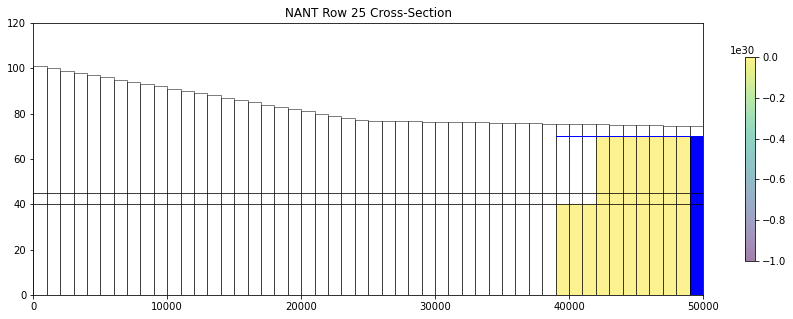

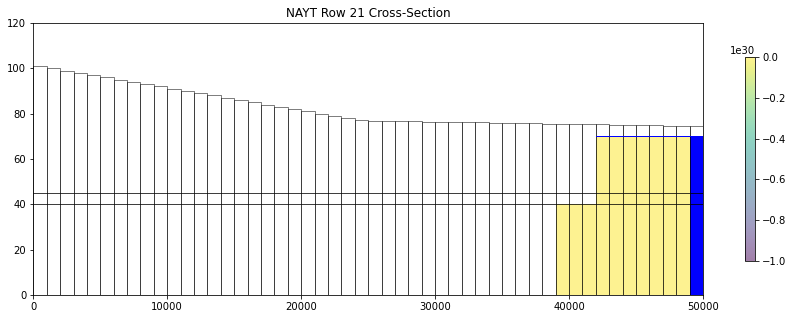

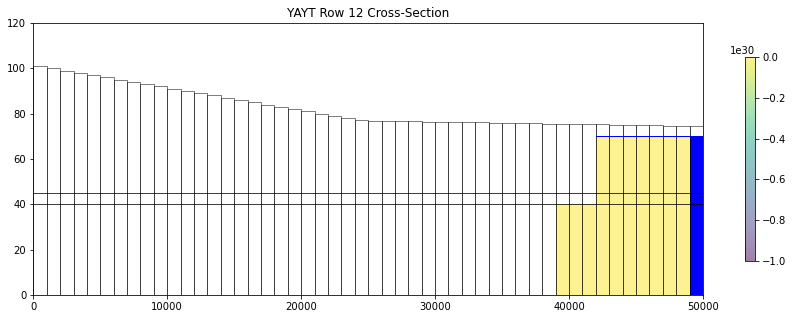

In [164]:
#### 1 layered model 
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m1, line={'row': 24}, extent=(0,50000,0,120)) #note use the key 'column' if you want to plot a column instaed
pc = xsect.plot_array(head1, masked_values=[999.], head=head3, alpha=0.5)
patches = xsect.plot_ibound(head=head1)
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('NANT Row 25 Cross-Section')
cb = plt.colorbar(pc, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect.plot_surface(head1[0,:,:], masked_values=[999.], color='blue', lw=1)

#### Model 2
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m2, line={'row': 24}, extent=(0,50000,0,120)) #note use the key 'column' if you want to plot a column instaed
pc = xsect.plot_array(head3, masked_values=[999.], head=head3, alpha=0.5)
patches = xsect.plot_ibound(head=head3)
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('NAYT Row 21 Cross-Section')
cb = plt.colorbar(pc, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect.plot_surface(head3[0,:,:], masked_values=[999.], color='blue', lw=1)


#### Model 3
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m3, line={'row': 24}, extent=(0,50000,0,120)) #note use the key 'column' if you want to plot a column instaed
pc = xsect.plot_array(head3, masked_values=[999.], head=head3, alpha=0.5)
patches = xsect.plot_ibound(head=head3)
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('YAYT Row 12 Cross-Section')
cb = plt.colorbar(pc, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect.plot_surface(head3[0,:,:], masked_values=[999.], color='blue', lw=1)

## 7. Head contours

C:\Users\LIFEBOOK\miniconda3\envs\gwmod\lib\site-packages\flopy\plot\map.py:819: DeprecationWarning: plot_discharge() has been deprecated and will be replaced in version 3.3.5. Use plot_vector() instead, which should follow after postprocessing.get_specific_discharge()
  warnings.warn(
C:\Users\LIFEBOOK\miniconda3\envs\gwmod\lib\site-packages\flopy\plot\plotutil.py:1630: DeprecationWarning: centered_specific_discharge() has been deprecated and will be removed in version 3.3.5. Use postprocessing.get_specific_discharge() instead.
  warnings.warn(
C:\Users\LIFEBOOK\miniconda3\envs\gwmod\lib\site-packages\flopy\plot\map.py:819: DeprecationWarning: plot_discharge() has been deprecated and will be replaced in version 3.3.5. Use plot_vector() instead, which should follow after postprocessing.get_specific_discharge()
  warnings.warn(
C:\Users\LIFEBOOK\miniconda3\envs\gwmod\lib\site-packages\flopy\plot\plotutil.py:1630: DeprecationWarning: centered_specific_discharge() has been deprecated and 

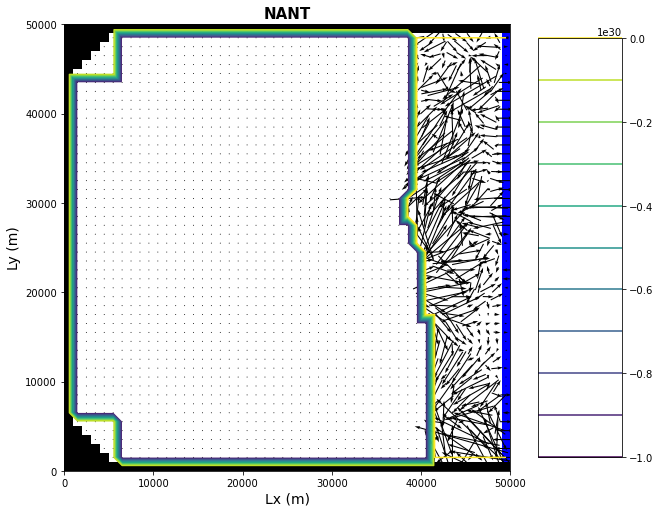

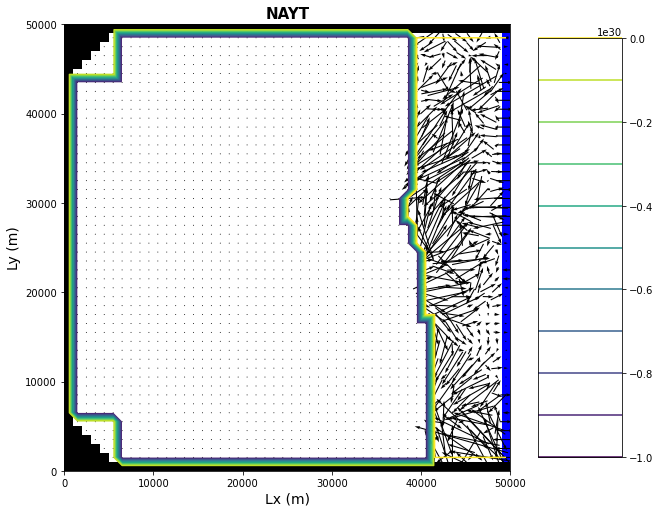

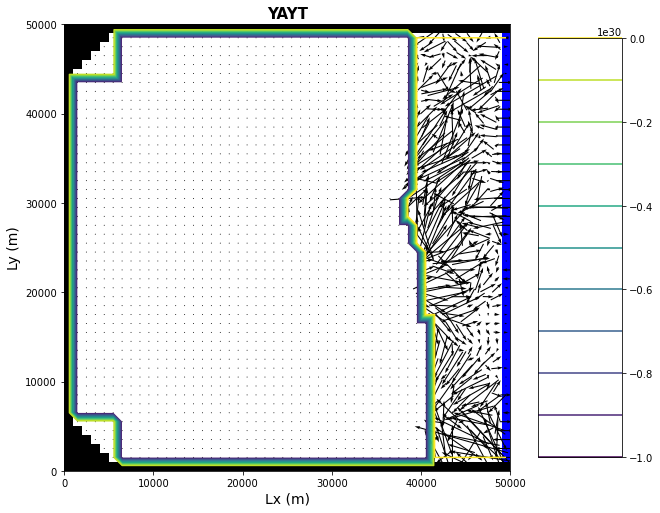

In [165]:
#f, axes = plt.subplots(ncols=1, nrows=2, figsize=(5, 10))
fig3=plt.figure(figsize=(10,10))

modelmap = flopy.plot.PlotMapView(model=m1, layer=0) #use modelmap to attach plot to model
#grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(head1[0].min(),head1[0].max(),11) #set contour levels for contouring head
head_contours = modelmap.contour_array(head1, levels=contour_levels) #create head contours
flows = modelmap.plot_discharge(frf1[0], fff1[0], head=head1) #create discharge arrows

#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('NANT', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)
#plt.show(modelmap)
#plt.savefig('WellScenario_vectors.png')   

#### NAYT
#f, axes = plt.subplots(ncols=1, nrows=2, figsize=(5, 10))
fig3=plt.figure(figsize=(10,10))

modelmap = flopy.plot.PlotMapView(model=m2, layer=0) #use modelmap to attach plot to model
#grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(head1[0].min(),head1[0].max(),11) #set contour levels for contouring head
head_contours = modelmap.contour_array(head1, levels=contour_levels) #create head contours
flows = modelmap.plot_discharge(frf1[0], fff1[0], head=head1) #create discharge arrows

#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('NAYT', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)
#plt.show(modelmap)
#plt.savefig('WellScenario_vectors.png') 

#f, axes = plt.subplots(ncols=1, nrows=2, figsize=(5, 10))
fig3=plt.figure(figsize=(10,10))

modelmap = flopy.plot.PlotMapView(model=m3, layer=0) #use modelmap to attach plot to model
#grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(head1[0].min(),head1[0].max(),11) #set contour levels for contouring head
head_contours = modelmap.contour_array(head1, levels=contour_levels) #create head contours
flows = modelmap.plot_discharge(frf1[0], fff1[0], head=head1) #create discharge arrows

#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('YAYT', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)
#plt.show(modelmap)
#plt.savefig('WellScenario_vectors.png') 